In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from operator import itemgetter
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly())

TF version:  2.11.0
Eager execution enabled:  True


x_train shape: (60000, 28, 28) y_train shape: (60000,)


10000

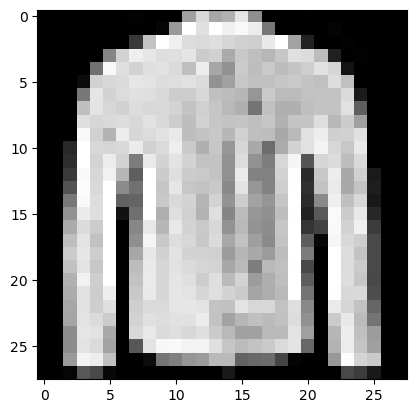

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[50]);len(x_test)

In [3]:
from keras.utils import to_categorical
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [23]:
# Load model
model = load_model('tf_fmnist_cnn_v2.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1]),x_test.shape

Test accuracy:  0.9157000184059143


(None, (10000, 28, 28, 1))

In [5]:
# load patterns respective to the model
patterns = np.load( 'patterns_fmnist_cnn.npy')

In [6]:
# Rank the patterns
temp_list = []
for i in patterns:
        
    m = model.predict(i, verbose=0).tolist()[0]
    b = m.index(max(m))
    
    o = max(m)
    m.remove(o)
    
    v = max(m)
    m.remove(v)
    
    f = o - v
    
    temp_list.append([i,b,o,f])
    

patterns = sorted(temp_list, key=itemgetter(3), reverse=False)

In [7]:
cc_weight = model.get_weights()

In [8]:
# Data format conversion
import struct

def bin2float(b):
    h = int(b, 2).to_bytes(8, byteorder="big")
    return struct.unpack('>d', h)[0]


def float2bin(f):
    [d] = struct.unpack(">Q", struct.pack(">d", f))
    return f'{d:064b}'

In [29]:
# Introduce fault into the model
def introduce_fault(model, x, l_ind, bit_ind, s):
    
    clean_weight = model.get_weights() 
    acc_new = 0
    w_new = copy.deepcopy(clean_weight) 
    wf1 = w_new[l_ind].flatten()
    
    if s is None:
        r = random.sample(range(0,len(wf1)),x)
    else:
        r = s
    
    for i in r:
        l1 = list(float2bin(wf1[i]))
        
        if l1[bit_ind] == '0':
            l1[bit_ind] = '1'
        else:
            l1[bit_ind] = '0'
            
        wf1[i] = bin2float("".join(l1))
        
    w_new[l_ind] = wf1.reshape(w_new[l_ind].shape)
    
    model.set_weights(w_new) 
    if s is None:
        
        score = model.evaluate(x_test, y_test, verbose=0)
        
        acc_new = score[1]
    
    
#     print("Updated model accuracy : ",acc_new)

    return r, acc_new

In [31]:
# Attack detection
import random, copy
model.set_weights(cc_weight)

# Fault injection into the model
t, acc = introduce_fault(model, 5, 0, 0, None)
print("Upon fault injection accuracy drops from", 91.57,"to",acc*100)

for j in range(len(patterns)):
    if model.predict(patterns[j][0]).argmax() != patterns[j][1]:
        print('Attack detected successfully')
        break
        

model.set_weights(cc_weight)

Upon fault injection accuracy drops from 91.57 to 90.35000205039978
1/1 [==============================] - 0s 17ms/step
Attack detected successfully


In [57]:
# Set covering
import copy, random
AttackSet = []
AccList = []
# cc_weight = model.get_weights()
model.set_weights(cc_weight)
PList = patterns[:20]
NumAttacks=100

# Creating attack set
for i in range(NumAttacks):
    AttackPos, temp = introduce_fault(model, 5, 0, 0, None)
    model.set_weights(cc_weight)
    AttackSet.append(AttackPos)
    AccList.append(temp)
# print(AttackSet)


PSet = []
flag = 0

# Covering the set with best performing patterns
while len(AttackSet)!= 0:
    print("Coverage cycle: ", flag+1)
    flag = flag+1
    Cover = {}
    
    for i in range(len(PList)):
        Cover[i] = []
    
    for a in AttackSet:
        introduce_fault(model, 5, 0, 0, a)
        for j in range(len(PList)) :
            pred = np.argmax(model(PList[j][0]))
            if pred != PList[j][1]:
                Cover[j].append(a)
        model.set_weights(cc_weight)
    
    temp = 0
    for i in Cover.keys() :
        if len(Cover[i]) >= len(Cover[temp]) :
            temp = i
            
    PSet.append(PList[temp])
    
    print(len(Cover[temp]))
    
    tempList = []
    for i in range(len(PList)):
        if i!=temp:
            tempList.append(i)
        
    for i in Cover[temp]:
        AttackSet.remove(i)
        
    if flag>=20:
        break

len(PSet), len(AttackSet)

Coverage cycle:  1
94
Coverage cycle:  2
6


(2, 0)

In [23]:
print(len(PSet),"patterns are needed to detect", NumAttacks, "instances of", 2, "random bit-flips in the first layer to furnish a", (NumAttacks-len(AttackSet))/NumAttacks*100, "% coverage")

5 patterns are needed to detect 100 instances of 2 random bit-flips in the first layer to furnish a 100.0 % coverage


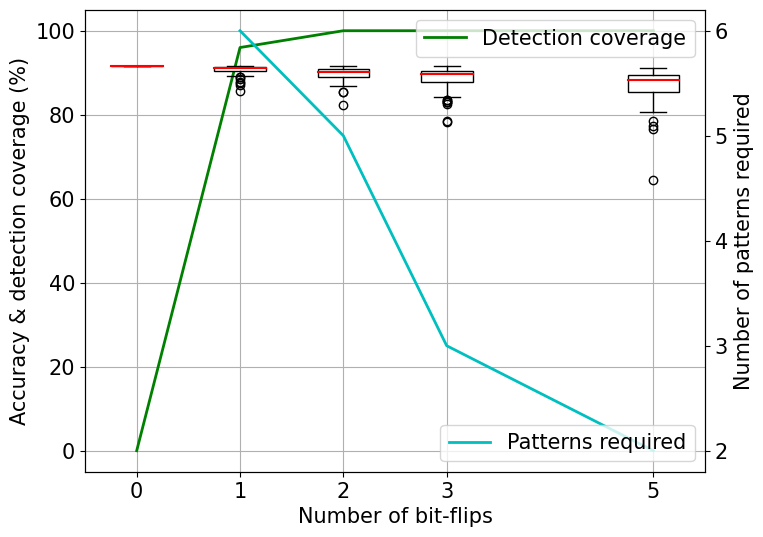

In [51]:
#FMNIST using only 10 patterns (both sign faults and stuck at faults)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
mpl.rcParams["font.size"] = 15
data1 = [acc_listg0, acc_listg1, acc_listg2, acc_listg3, acc_listg5]
fig, ax = plt.subplots(figsize = (8, 6))
x=[0, 1, 2, 3, 5]
Num_of_faults = [0, 1, 2, 3, 5]
fault_coverage = [0, 96, 100, 100, 100]
PatternsNeeded = [None, 6, 5,3, 2]
ax2 = ax.twinx()
# ax.plot(Num_of_faults,Accuracy,label = "Accuracy",linewidth=2)
ax.plot(Num_of_faults,fault_coverage,linewidth=2, label = "Detection coverage",color='g')
ax2.plot(Num_of_faults,PatternsNeeded, label = "Patterns required",linewidth=2, color='c')
ax.boxplot(data1,  positions=x, patch_artist=True,boxprops=dict(facecolor='w'),
          medianprops = dict(color="r",linewidth=1.5))
# plt.plot(y,x3,label = "Other Layers",linewidth=2)
# plt.title("Losses due to layer-wise top-k gradient weight flips")
ax.set_ylabel('Accuracy & detection coverage (%)', fontsize=15)
ax.set_xlabel('Number of bit-flips', fontsize=15)
ax2.set_xlabel('Number of bit-flips', fontsize=15)
ax2.set_ylabel('Number of patterns required', fontsize=15)
ax.legend(loc='upper right')
ax2.legend(loc='lower right')
# ax2.yticks([0,1,2,3,4,5,6])
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()
# plt.legend(loc='lower center')
plt.show()